# Data Cleaning

## Import and Aggregate Data

In [1209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from mlxtend.frequent_patterns import apriori, fpgrowth
# a = pd.read_csv('worldriskindex-datasets\worldriskindex-2000.csv')
# a.info()


a = pd.DataFrame()

link = 'worldriskindex-datasets\worldriskindex-'
for y in range(2000,2024):
    b = pd.read_csv(f"{link}{y}.csv")
    
    if ("Year" not in b.columns):
        b["Year"] = y

    if ("WRI.Country" in b.columns):
        b.rename(columns={'WRI.Country': 'Country'}, inplace=True)
        
    if ("ISO3.Code" in b.columns):
        b.rename(columns={'ISO3.Code': 'ISO3'}, inplace=True)
    
    a = pd.concat([a, b], axis=0)

# delete attr
a.drop(columns=["SI_10_Norm", "SI_10_Base", "SI_11_Norm"], inplace=True)
a.info(verbose=True)


<>:16: DeprecationWarning: invalid escape sequence '\w'
<>:16: DeprecationWarning: invalid escape sequence '\w'
C:\Users\Avinandan\AppData\Local\Temp\ipykernel_5572\1310798143.py:16: DeprecationWarning: invalid escape sequence '\w'
  link = 'worldriskindex-datasets\worldriskindex-'


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4632 entries, 0 to 192
Data columns (total 245 columns):
 #    Column       Dtype  
---   ------       -----  
 0    Country      object 
 1    ISO3         object 
 2    W            float64
 3    E            float64
 4    V            float64
 5    S            float64
 6    C            float64
 7    A            float64
 8    S_01         float64
 9    S_02         float64
 10   S_03         float64
 11   S_04         float64
 12   S_05         float64
 13   C_01         float64
 14   C_02         float64
 15   C_03         float64
 16   A_01         float64
 17   A_02         float64
 18   A_03         float64
 19   EI_01        float64
 20   EI_02        float64
 21   EI_03        float64
 22   EI_04        float64
 23   EI_05        float64
 24   EI_06        float64
 25   EI_07        float64
 26   SI_01        float64
 27   SI_02        float64
 28   SI_03        float64
 29   SI_04        float64
 30   SI_05        float64
 3

We find that there are inconsistency in columns
```
WRI.Country  > Rename Attr
ISO3.Code  > Rename Attr
Year  >  Add where missing
SI_10_Norm > DROP
SI_10_Base > DROP
SI_11_Norm > DROP
```

# Data Description and Statistical Analysis

We choose groups of attributes as follows:
- Group 1: ['W', 'E', 'V', 'S', 'C', 'A']
- Group 2: ['E', 'EI_01', 'EI_02', 'EI_03', 'EI_04', 'EI_05', 'EI_06', 'EI_07']
- Group 3: ['S', 'S_01', 'S_02', 'S_03', 'S_04', 'S_05']
- Group 4: ['C', 'C_01', 'C_02', 'C_03']
- Group 5: ['A', 'A_01', 'A_02', 'A_03']


Operations performed: 
- Min-max normalization
- Statistical Measure Analysis
- Correlation Analysis

In [1210]:
COLUMNS = a.columns
group1_cols = ["W", "E", "V", "S", "C", "A"]
group2_cols = [c for c in COLUMNS if "E" in c and "Norm" not in c and "Base" not in c]
group3_cols = [c for c in COLUMNS if "S" in c and "I" not in c]
group4_cols = [c for c in COLUMNS if "C" in c and "I" not in c and c != "Country"]
group5_cols = [c for c in COLUMNS if "A" in c and "I" not in c]
data_cols = (["Country", "Year"]+group1_cols+group2_cols[1:]+group3_cols[1:]+group4_cols[1:]+group5_cols[1:])
# data = list(set(data))
print(f"Group 1: {group1_cols}\nGroup 2: {group2_cols}\nGroup 3: {group3_cols}\nGroup 4: {group4_cols}\nGroup 5: {group5_cols}")
print(f"Selected Columns: {data_cols}")
group1 = a[group1_cols].copy()
group2 = a[group2_cols].copy()
group3 = a[group3_cols].copy()
group4 = a[group4_cols].copy()
group5 = a[group5_cols].copy()
data = a[data_cols].copy()


Group 1: ['W', 'E', 'V', 'S', 'C', 'A']
Group 2: ['E', 'EI_01', 'EI_02', 'EI_03', 'EI_04', 'EI_05', 'EI_06', 'EI_07']
Group 3: ['S', 'S_01', 'S_02', 'S_03', 'S_04', 'S_05']
Group 4: ['C', 'C_01', 'C_02', 'C_03']
Group 5: ['A', 'A_01', 'A_02', 'A_03']
Selected Columns: ['Country', 'Year', 'W', 'E', 'V', 'S', 'C', 'A', 'EI_01', 'EI_02', 'EI_03', 'EI_04', 'EI_05', 'EI_06', 'EI_07', 'S_01', 'S_02', 'S_03', 'S_04', 'S_05', 'C_01', 'C_02', 'C_03', 'A_01', 'A_02', 'A_03']


In [1211]:
# Min-max normalization function
def min_max_norm(column):
    return (column - column.min()) / (column.max() - column.min())

### Group 1: Main data


Columns: ["W", "E", "V", "S", "C", "A"]

| Attribute | Description |
| ----------- | ----------- |
| W | WorldRiskIndex |
| E | Exposition |
| V | Vulnerability |
| S | Susceptibility |
| C | Lack Of Coping Capacities |
| A | Lack Of Adaptive Capacities |


Interesting Findings:
- After normalization, "W" (World Risk Index) has a mean of 0.167 and a median (50th percentile) of 0.082. Therefore the distribution is *Positively Skewed*. 
- Investigating the correlation, "A" (Lack Of Adaptive Capacities) appears almost unrelated in the overall measure, "W" (World Risk Index). However, "S" (Susceptibility) is positively correlated with both "C" (Lack of Coping Capacities) and "A" (Lack Of Adaptive Capacities)
- Also further analyzing the correlation, "W" (World Risk index) is much more positively correlated with "E" (Exposition) than "V" (Vulnerability).

In [1212]:
group1 = group1.apply(min_max_norm)
group1.describe()

,W,E,V,S,C,A
count,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000
mean,0.167458,0.082184,0.291236,0.271895,0.218979,0.500267
std,0.194425,0.155649,0.225513,0.231861,0.237613,0.224752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.042110,0.003407,0.118896,0.092801,0.071917,0.336610
50%,0.082943,0.015952,0.234749,0.195520,0.130979,0.521103
75%,0.216823,0.080688,0.382558,0.390905,0.172351,0.681384
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


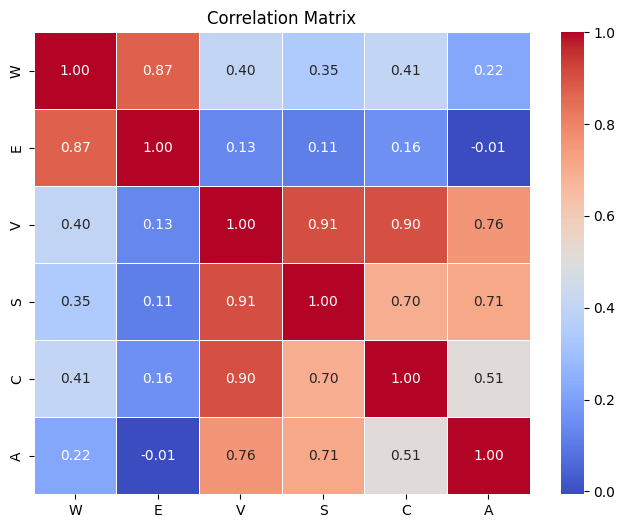

In [1213]:
group1_corr = group1.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(group1_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### Group 2: Exposition

Columns: ['E', 'EI_01', 'EI_02', 'EI_03', 'EI_04', 'EI_05', 'EI_06', 'EI_07']

| Attribute | Description |
| ----------- | ----------- |
| E | Exposition |
| EI_01 | Earthquakes |
| EI_02 | Tsunamis |
| EI_03 | Coastal Floodings |
| EI_04 | Riverine Floodings |
| EI_05 | Cyclones |
| EI_06 | Droughts |
| EI_07 | Sea Level Rise |

Interesting Findings:
- After normalization in group 2, "E" (Exposition) has a mean of 0.082 whereas the 50th percentile (median) is 0.016. Therefore the distribution is *Positively Skewed*. The same also applies for all attributes in group 2, except "EI_04" and "EI_07".
- Upon Correlation analysis of group 2, we find that the most Exposition Indicators (EI_XX) are independent of each other.

In [1214]:
group2 = group2.apply(min_max_norm)
group2.describe()

,E,EI_01,EI_02,EI_03,EI_04,EI_05,EI_06,EI_07
count,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000
mean,0.082184,0.224165,0.219325,0.224625,0.349067,0.046679,0.184837,0.361000
std,0.155649,0.290987,0.291671,0.259789,0.242826,0.174194,0.294420,0.265084
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003407,0.001308,0.000000,0.000000,0.175696,0.000000,0.002267,0.000000
50%,0.015952,0.027239,0.001777,0.027328,0.350780,0.000000,0.033725,0.390221
75%,0.080688,0.529559,0.492257,0.413939,0.517706,0.001784,0.145813,0.553312
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


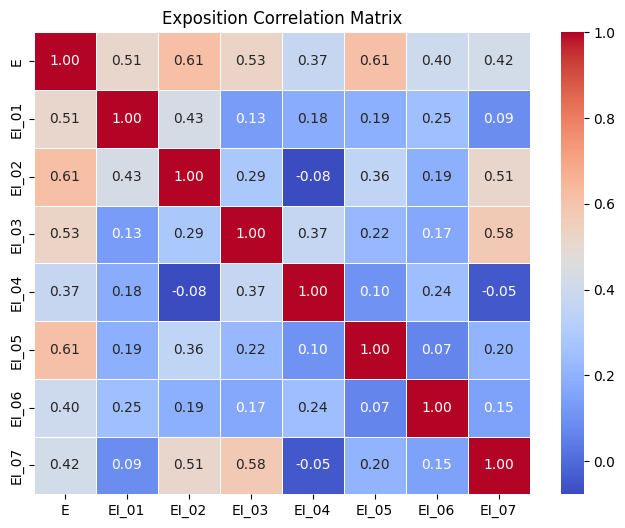

In [1215]:
group2_corr = group2.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(group2_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Exposition Correlation Matrix")
plt.show()

### Group 3: Susceptibility

Columns: ['S', 'S_01', 'S_02', 'S_03', 'S_04', 'S_05']

| Attribute | Description |
| ----------- | ----------- |
| S | Susceptibility |
| S_01 | Socio-Economic Development |
| S_02 | Socio-Economic Deprivation |
| S_03 | Societal Disparities |
| S_04 | Vulnerable Populations Due To Violence, Conflicts And Disaster |
| S_05 | Vulnerable Populations Due To Diseases And Epidemics |

Interesting Findings:
- In the Correlation Matrix for group 3, except for "S_04", there moderately positive correlation between all the attributes.


In [1216]:
group3 = group3.apply(min_max_norm)
group3.describe()

,S,S_01,S_02,S_03,S_04,S_05
count,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000
mean,0.271895,0.606387,0.349137,0.535084,0.101110,0.572508
std,0.231861,0.206906,0.286303,0.178665,0.212307,0.195683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.092801,0.467047,0.042388,0.402315,0.001949,0.438219
50%,0.195520,0.638029,0.394029,0.546408,0.008381,0.586481
75%,0.390905,0.773591,0.593807,0.662370,0.036642,0.720485
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


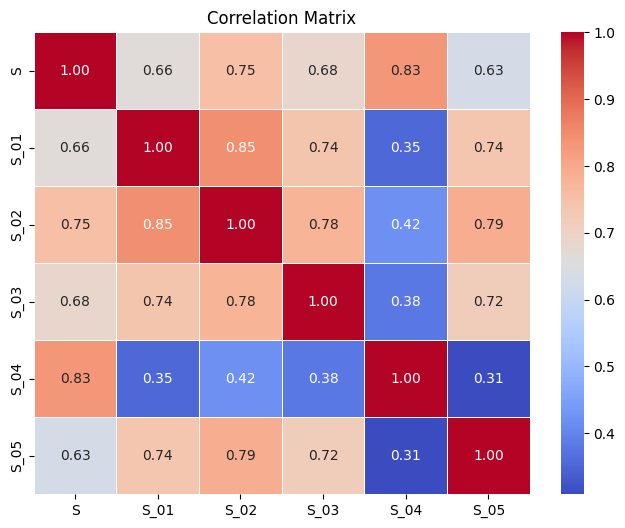

In [1217]:
group3_corr = group3.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(group3_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### Group 4: Lack Of Coping Capacities

Columns: ['C', 'C_01', 'C_02', 'C_03']

| Attribute | Description |
| ----------- | ----------- |
| C | Lack Of Coping Capacities |
| C_01 | Recent Societal Shocks |
| C_02 | State And Government |
| C_03 | Health Care Capacities |

Interesting Findings:
- "C_01" (Recent Societal Shocks) is very highly correlated with the calculated "C" (Lack Of Coping Capacities).

In [1218]:
group4 = group4.apply(min_max_norm)
group4.describe()

,C,C_01,C_02,C_03
count,4632.000000,4632.000000,4632.000000,4632.000000
mean,0.218979,0.125705,0.495090,0.520814
std,0.237613,0.238442,0.172716,0.193726
min,0.000000,0.000000,0.000000,0.000000
25%,0.071917,0.004673,0.376038,0.383076
50%,0.130979,0.007130,0.507701,0.518904
75%,0.172351,0.009826,0.615612,0.674302
max,1.000000,1.000000,1.000000,1.000000


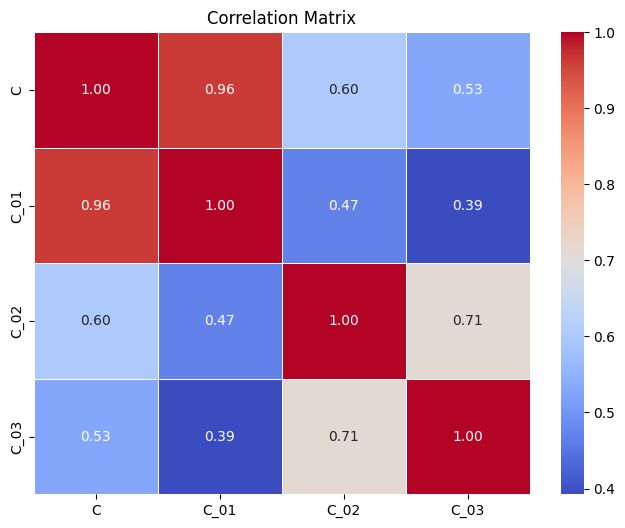

In [1219]:
group4_corr = group4.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(group4_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### Group 5: Lack Of Adaptive Capacities

Columns: ['A', 'A_01', 'A_02', 'A_03']

| Attribute | Description |
| ----------- | ----------- |
| A | Lack Of Adaptive Capacities |
| A_01 | Research And Education |
| A_02 | Long-Term Health And Deprivation Effects |
| A_03 | Investment Capacities |

Interesting Findings:
- Among all the attributes of group 5, "A_02" has the most positive correlation with "A".

In [1220]:
group5 = group5.apply(min_max_norm)
group5.describe()

,A,A_01,A_02,A_03
count,4632.000000,4632.000000,4632.000000,4632.000000
mean,0.500267,0.572713,0.408587,0.474560
std,0.224752,0.184593,0.235115,0.159549
min,0.000000,0.000000,0.000000,0.000000
25%,0.336610,0.443091,0.269231,0.365512
50%,0.521103,0.573261,0.405697,0.483148
75%,0.681384,0.718616,0.591460,0.586934
max,1.000000,1.000000,1.000000,1.000000


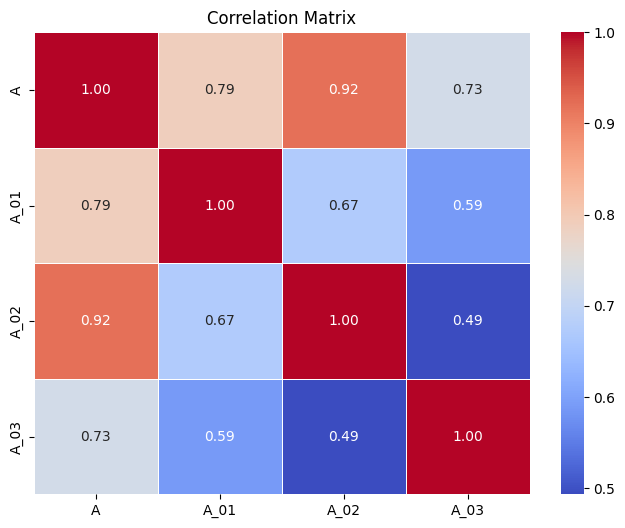

In [1221]:
group5_corr = group5.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(group5_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

# Discretization

We discretize the numerical data attributes to facilitate pattern mining.
For discretization, we choose the attributes in group 1.


## Categorical Encoding

All the numeric columns were discretized by their quartiles (Q1, Q2, Q3, Q4).

In [1222]:
discrete_columns = group1_cols

discrete_data = data[discrete_columns].copy()

for col in group1_cols:
    custom_labels = [col+'=Q1', col+'=Q2', col+'=Q3', col+'=Q4']
    discrete_data[col] = pd.qcut(discrete_data[col], q=4, labels=custom_labels)


discrete_data.head()


,W,E,V,S,C,A
0,W=Q3,E=Q2,V=Q4,S=Q4,C=Q4,A=Q4
1,W=Q3,E=Q3,V=Q2,S=Q2,C=Q4,A=Q1
2,W=Q3,E=Q3,V=Q4,S=Q3,C=Q4,A=Q2
3,W=Q1,E=Q1,V=Q1,S=Q1,C=Q1,A=Q1
4,W=Q4,E=Q3,V=Q4,S=Q4,C=Q4,A=Q4


## Bit map encoding 

In order to use the data in pattern mining algorithms, we need binary bitmap / one hot encoded data.

In [1223]:
data_encoded = pd.get_dummies(discrete_data.stack()).groupby(level=0).sum()
data_encoded = data_encoded.astype(bool)

data_encoded.head()

,A=Q1,A=Q2,A=Q3,A=Q4,C=Q1,C=Q2,C=Q3,C=Q4,E=Q1,E=Q2,...,S=Q3,S=Q4,V=Q1,V=Q2,V=Q3,V=Q4,W=Q1,W=Q2,W=Q3,W=Q4
0,False,False,True,True,False,False,False,True,False,True,...,False,True,False,False,False,True,False,True,True,False
1,True,True,False,False,False,True,True,True,False,False,...,False,False,True,True,True,False,False,False,True,False
2,True,True,True,False,False,False,False,True,False,False,...,True,False,False,False,True,True,False,False,True,True
3,True,True,False,False,True,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
4,False,False,False,True,False,False,True,True,False,False,...,True,True,False,False,True,True,False,False,True,True


# Pattern Mining

## FP-Growth

In [1224]:
# Run FP-Growth to find frequent itemsets with a minimum support of 0.4 (40%)
frequent_itemsets_fpg = fpgrowth(data_encoded, min_support=0.4, use_colnames=True)

# Print the frequent itemsets
frequent_itemsets_fpg

,support,itemsets
0,0.549223,(A=Q3)
1,0.435233,(C=Q4)
2,0.424870,(V=Q4)
3,0.637306,(A=Q2)
4,0.601036,(S=Q2)
5,0.590674,(A=Q1)
6,0.559585,(V=Q3)
7,0.538860,(V=Q2)
8,0.502591,(C=Q2)
9,0.497409,(C=Q3)


## Apriori

In [1225]:
# Run Apriori to find frequent itemsets with a minimum support of 0.4 (40%)
frequent_itemsets_apr = apriori(data_encoded, min_support=0.4, use_colnames=True)

# Print the frequent itemsets
frequent_itemsets_apr

,support,itemsets
0,0.590674,(A=Q1)
1,0.637306,(A=Q2)
2,0.549223,(A=Q3)
3,0.497409,(C=Q1)
4,0.502591,(C=Q2)
5,0.497409,(C=Q3)
6,0.435233,(C=Q4)
7,0.414508,(S=Q1)
8,0.601036,(S=Q2)
9,0.569948,(S=Q3)


# Clustering

## Clustering tendency

Hopkin Statistic


Findings: 
- Hopkin Statistic in ["E", "V"] = ~0.10
- Hopkin Statistic in ["A", "S", "C"] = ~0.30
- Hopkin Statistic in ["E", "A", "S", "C"] = ~0.20
- Hopkin Statistic in ["W", "E", "A", "S", "C"] = ~0.16
 

In [1226]:

def hopkins_statistic(X, n):
    d = X.shape[1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    
    rand_X = np.random.rand(n, d)
    y_dist, _ = nbrs.kneighbors()
    x_dist, _ = nbrs.kneighbors(rand_X)
    print(f"np.sum(y_dist) / (np.sum(y_dist) + np.sum(x_dist)) = {np.sum(y_dist)} / ({np.sum(y_dist)} + {np.sum(x_dist)})")
    H = np.sum(y_dist) / (np.sum(y_dist) + np.sum(x_dist))
    return H

In [1227]:
df = group1[["E", "V"]].copy()

X = df.values

# Calculate Hopkins statistic
hopkins_value = hopkins_statistic(X, 1000)
print("Hopkins Statistic:", hopkins_value)

np.sum(y_dist) / (np.sum(y_dist) + np.sum(x_dist)) = 7.9763826141537795 / (7.9763826141537795 + 73.62150205632939)
Hopkins Statistic: 0.09775232098681007


In [1228]:
df = group1[["A", "S", "C"]].copy()

X = df.values

# Calculate Hopkins statistic
hopkins_value = hopkins_statistic(X, 1000)
print("Hopkins Statistic:", hopkins_value)

np.sum(y_dist) / (np.sum(y_dist) + np.sum(x_dist)) = 49.205137515141956 / (49.205137515141956 + 120.79108193004608)
Hopkins Statistic: 0.2894484222986335


In [1229]:
df = group1[["E", "A", "S", "C"]].copy()

X = df.values

# Calculate Hopkins statistic
hopkins_value = hopkins_statistic(X, 1000)
print("Hopkins Statistic:", hopkins_value)

np.sum(y_dist) / (np.sum(y_dist) + np.sum(x_dist)) = 67.07901747701649 / (67.07901747701649 + 249.81859907113002)
Hopkins Statistic: 0.21167409905976722


In [1230]:
df = group1[["W", "E", "A", "S", "C"]].copy()

X = df.values

# Calculate Hopkins statistic
hopkins_value = hopkins_statistic(X, 1000)
print("Hopkins Statistic:", hopkins_value)

np.sum(y_dist) / (np.sum(y_dist) + np.sum(x_dist)) = 76.16171556853602 / (76.16171556853602 + 378.5726055818518)
Hopkins Statistic: 0.1674861826480613


## Clustering algorithms

We choose the 3 most important attributes in our data: "W", "E", "V" for clustering purpose.


In [1231]:
df = group1[["W", "E", "V"]].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

### K-Means

In [1232]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the DataFrame
df['KMeans'] = kmeans.labels_

df.head()


,W,E,V,KMeans
0,0.084432,0.003562,0.920195,2
1,0.134198,0.036549,0.211687,0
2,0.214164,0.040731,0.509266,2
3,0.002127,0.000000,0.039497,0
4,0.230540,0.033452,0.727715,2


### K-Medoids / PAM

In [1233]:
# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=3, random_state=42)
kmedoids.fit(scaled_data)

# Add cluster labels to the DataFrame
df['KMedoids'] = kmedoids.labels_

df.head()

,W,E,V,KMeans,KMedoids
0,0.084432,0.003562,0.920195,2,1
1,0.134198,0.036549,0.211687,0,2
2,0.214164,0.040731,0.509266,2,1
3,0.002127,0.000000,0.039497,0,2
4,0.230540,0.033452,0.727715,2,1


### DBSCAN


In [1234]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=3)
clusters = dbscan.fit_predict(scaled_data)

# Add cluster labels to the DataFrame
df['DBSCAN'] = clusters

df.head()

,W,E,V,KMeans,KMedoids,DBSCAN
0,0.084432,0.003562,0.920195,2,1,0
1,0.134198,0.036549,0.211687,0,2,0
2,0.214164,0.040731,0.509266,2,1,0
3,0.002127,0.000000,0.039497,0,2,0
4,0.230540,0.033452,0.727715,2,1,0


## Displaying the Clusters

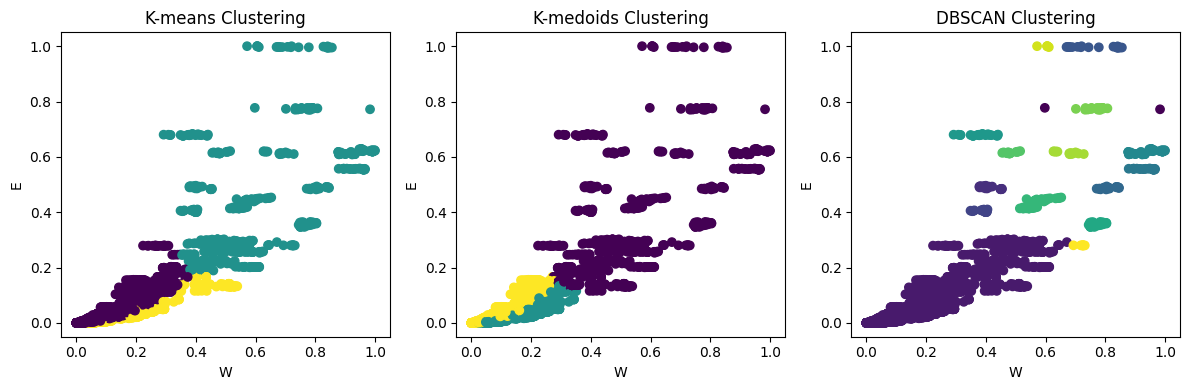

In [1245]:
c1, c2 = "W", "E"

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Visualize K-means Clustering
axes[0].scatter(df[c1], df[c2], c=df['KMeans'], cmap='viridis')
axes[0].set_xlabel(c1)
axes[0].set_ylabel(c2)
axes[0].set_title('K-means Clustering')

# Visualize K-medoids Clustering
axes[1].scatter(df[c1], df[c2], c=df['KMedoids'], cmap='viridis')
axes[1].set_xlabel(c1)
axes[1].set_ylabel(c2)
axes[1].set_title('K-medoids Clustering')

# Visualize DBSCAN Clustering
axes[2].scatter(df[c1], df[c2], c=df['DBSCAN'], cmap='viridis')
axes[2].set_xlabel(c1)
axes[2].set_ylabel(c2)
axes[2].set_title('DBSCAN Clustering')

plt.tight_layout()
plt.show()

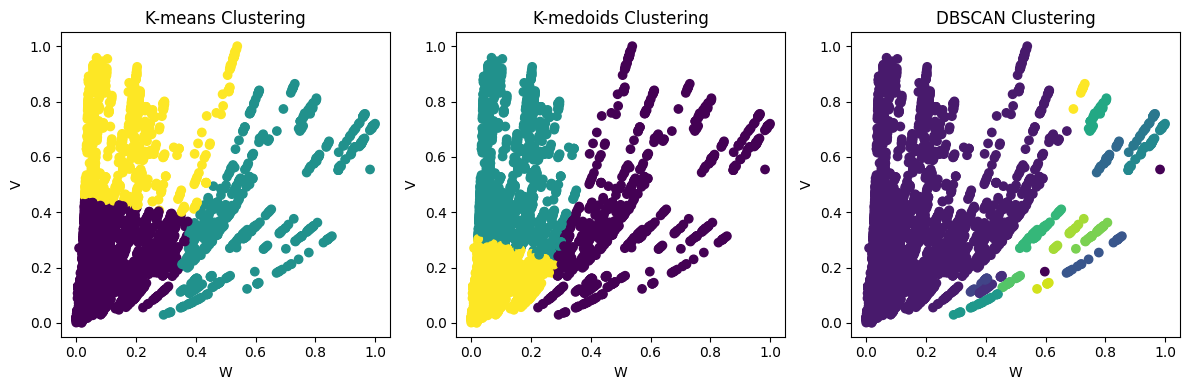

In [1246]:
c1, c2 = "W", "V"

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Visualize K-means Clustering
axes[0].scatter(df[c1], df[c2], c=df['KMeans'], cmap='viridis')
axes[0].set_xlabel(c1)
axes[0].set_ylabel(c2)
axes[0].set_title('K-means Clustering')

# Visualize K-medoids Clustering
axes[1].scatter(df[c1], df[c2], c=df['KMedoids'], cmap='viridis')
axes[1].set_xlabel(c1)
axes[1].set_ylabel(c2)
axes[1].set_title('K-medoids Clustering')

# Visualize DBSCAN Clustering
axes[2].scatter(df[c1], df[c2], c=df['DBSCAN'], cmap='viridis')
axes[2].set_xlabel(c1)
axes[2].set_ylabel(c2)
axes[2].set_title('DBSCAN Clustering')

plt.tight_layout()
plt.show()

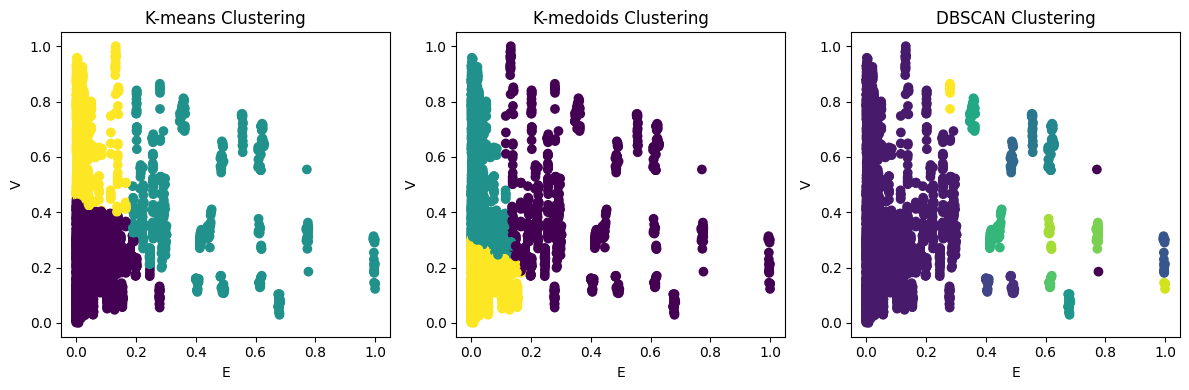

In [1247]:
c1, c2 = "E", "V"

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Visualize K-means Clustering
axes[0].scatter(df[c1], df[c2], c=df['KMeans'], cmap='viridis')
axes[0].set_xlabel(c1)
axes[0].set_ylabel(c2)
axes[0].set_title('K-means Clustering')

# Visualize K-medoids Clustering
axes[1].scatter(df[c1], df[c2], c=df['KMedoids'], cmap='viridis')
axes[1].set_xlabel(c1)
axes[1].set_ylabel(c2)
axes[1].set_title('K-medoids Clustering')

# Visualize DBSCAN Clustering
axes[2].scatter(df[c1], df[c2], c=df['DBSCAN'], cmap='viridis')
axes[2].set_xlabel(c1)
axes[2].set_ylabel(c2)
axes[2].set_title('DBSCAN Clustering')

plt.tight_layout()
plt.show()

# UNUSED CODES

In [1239]:
# x = ["Year"]

# for c in a.columns:
#     if ("SI_10" in c):
#         x.append(c)

# p = a[x]
# p.head()

In [1240]:
# p.tail()

In [1241]:
# p.describe()

In [1242]:
# #Calculating S10_Base
# import pandas as pd
# d = pd.read_csv('worldriskindex-datasets\worldriskindex-2000.csv')
# #print(d.columns)

# x = []

# for c in d.columns:
#     if ("SI_10" in c):
#         x.append(c)
# #print(d[x].shape)
# year = pd.DataFrame({'Year': [2000] * 193})
# s_2000 = pd.concat([year, d[x]],axis = 1)

# #Creating S_10_Base

# s_2000["SI_10_Base"] = s_2000["SI_10a_Base"] + s_2000["SI_10b_Base"]

 

# # columns_to_normalize = ["SI_10a_Norm","SI_10b_Norm"]
# # s_2000['SI_10_Norm'] = s_2000[columns_to_normalize].apply(min_max_normalize, axis=1)
# # s_2000.head()

In [1243]:
# columns_to_discretize = [col for col in data.columns if col not in ['Country', 'Year']]
# discrete_columns = ["Country", "Year"]
# # Discretize the selected columns by quartiles
# for col in columns_to_discretize:
#     # Use value_counts to determine the unique values and their frequencies
#     value_counts = data[col].value_counts().sort_index()
    
#     # Calculate cumulative frequency
#     cum_freq = value_counts.cumsum()
    
#     # Determine quartile boundaries based on cumulative frequency
#     n = cum_freq.iloc[-1]
#     quartile_boundaries = [0, n//4, n//2, 3*n//4, n]
    
#     # Assign quartile labels based on quartile boundaries
#     quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']
#     data[col + '_q'] = pd.cut(data[col], bins=quartile_boundaries, labels=quartile_labels)

#     discrete_columns.append(col + '_q')

# discrete_data = data[discrete_columns]
# discrete_data.head()

In [1244]:
# print("Help! Please\n :')")